In [87]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

In [144]:
def get_jacobian( net, x, noutputs, batch, controls, output_dim=0):
        x = x.detach().clone()
        x = x.squeeze()

        n = x.size()[0]
        x = x.unsqueeze(1)
        x = x.repeat(1, noutputs, 1)
        controls = controls.unsqueeze(1)
        controls = controls.repeat(1, noutputs, 1)
        x.requires_grad_(True)
        y = net(x, controls)
        
        mask = torch.eye(noutputs).repeat(batch, 1, 1).to(x.device)
        if type(y) is tuple:
            y[output_dim].backward(mask, create_graph=True)
        else:
            y.backward(mask, create_graph=True)

        return x.grad
    
def get_jacobian_new(net, x, noutputs, batch, controls, output_dim=0):
        x = x.detach().clone()
        x = x.squeeze()

        n = x.size()[0]
        x = x.unsqueeze(1)
        x = x.repeat(1, noutputs, 1)
        controls = controls.unsqueeze(1)
        controls = controls.repeat(1, noutputs, 1)
        x.requires_grad_(True)
        y = net(x, controls)
        
        mask = torch.eye(noutputs).repeat(batch, 1, 1).to(x.device)
        if type(y) is tuple:
            y = y[output_dim]
        grad_auto = torch.autograd.grad(y, x, mask, create_graph=True)
        print(grad_auto)
        return grad_auto[0]

In [142]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size, bias=False)
        self.layer2 = nn.Linear(input_size, hidden_size, bias=False)

        nn.init.xavier_uniform(self.layer1.weight.data)
        self.input_size = input_size

    def forward(self, i, o):
        x = self.layer1(i**2)

#         x1 = self.layer1(o)
        
#         x1 = self.layer1(x[:, :self.input_size])
#         x2 = self.layer1(x[:, self.input_size:])
        
        return x, 2
    
  

In [134]:
net = Net(2, 2, 1)

/Users/michelle/miniconda3/envs/filter/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [135]:
x_np = np.random.normal(0, 0.5, (2,2))
y = np.ones((2, 2)) * 0.5
x = torch.from_numpy(x_np).float()
y = torch.from_numpy(y).float()
print("x: ", x)

net.layer1.weight.data = torch.ones((2,2))

x:  tensor([[-0.4363,  0.3399],
        [ 1.0818, -0.2460]])


In [136]:
print(net(x, y))

(tensor([[0.3059, 0.3059],
        [1.2307, 1.2307]], grad_fn=<MmBackward>), 2)


In [137]:
np.sum(x_np**2,1)


array([0.30592198, 1.23071354])

In [143]:
jacobian = get_jacobian_new(net, x, 2, 2, y)
old = get_jacobian(net, x, 2, 2, y)


optimizer = optim.Adam(net.parameters(), lr=0.001)

    

(tensor([[[-0.8726,  0.6799],
         [-0.8726,  0.6799]],

        [[ 2.1635, -0.4919],
         [ 2.1635, -0.4919]]], grad_fn=<MulBackward0>),)


In [131]:
losses = []

for i in range(10000):
    x_np = np.ones((2,2))
    y = np.ones((2, 2)) * 0.5
    x = torch.from_numpy(x_np).float()
    y = torch.from_numpy(y).float()
    jac = get_jacobian_new(net, x, 2, 2, y)
    loss = F.mse_loss(jac, torch.ones(2,2,2))
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    

tensor([[[1.0000, 1.0000],
         [1.0000, 1.0000]],

        [[1.0000, 1.0000],
         [1.0000, 1.0000]]], grad_fn=<MulBackward0>)


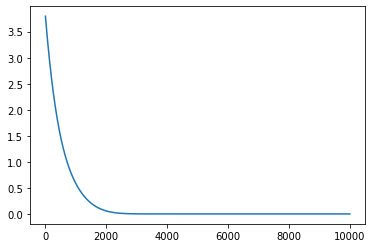

In [132]:
import matplotlib.pyplot as plt

plt.plot(np.array(losses))

print(jac)

In [36]:
t1 = torch.zeros((5, 3, 2))
t2 = torch.zeros((5, 2, 4))

In [75]:
torch.bmm(t1, t2).shape

torch.Size([5, 3, 4])